In [131]:
import re
import collections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import spacy
import contextualSpellCheck
import textstat

from keras import models
from keras import layers
from keras import regularizers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer

In [132]:
data = pd.read_csv('Data/data.csv')
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [133]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_elements(input_text):
    text = re.sub(r'@\w+', '', input_text) # Removes tweet mentiones
    text = re.sub(r"\S*https?:\S*", "", text) # Removes URL's
    return text
       
data['Sentence'] = data['Sentence'].apply(remove_stopwords).apply(remove_elements)
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology leverage Benefon '...,positive
1,"$ESI lows, $1.50 $2.50 BK real possibility",negative
2,For last quarter 2010 Componenta 's net sales ...,positive
3,According Finnish-Russian Chamber Commerce maj...,neutral
4,The Swedish buyout firm sold remaining 22.4 pe...,neutral


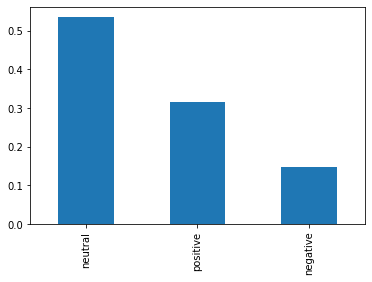

In [134]:
data['Sentiment'].value_counts(normalize=True).plot(kind='bar')
# There is definately a skew here, lets make sure to stratify the train test split to ensure.

In [141]:
data_2 = data.copy()

#spell_check_nlp = spacy.load('en_core_web_sm')
#contextualSpellCheck.add_to_pipe(spell_check_nlp)

data_2['Flesch_Score'] = data['Sentence'].map(textstat.flesch_reading_ease)
data_2['Gunning_FOG_Score'] = data['Sentence'].map(textstat.gunning_fog)
data_2.groupby('Sentiment').agg({"Flesch_Score": [np.mean, np.std], "Gunning_FOG_Score" : [np.mean, np.std]})

Flesch_Score            Gunning_FOG_Score          
                  mean        std              mean       std
Sentiment                                                    
negative     60.952023  28.648497          8.198244  5.269671
neutral      38.672476  33.173451         11.992026  6.216698
positive     52.549163  33.511161          9.752970  6.080809

These scores are wild, the standard deviation of the scores are almost the mean.

Gameplan for this model:
    - N-Grams
    - Keras model
    - Spacy model
    - Voting model

In [22]:
# General Settings
NB_WORDS = 10000
VAL_SIZE = 1000
NB_START_EPOCHS = 20
BATCH_SIZE = 512

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    data['Sentence'],
    data['Sentiment'],
    test_size = 0.3,
    stratify = data['Sentiment'],
    random_state = 42
)

print(f'We have {X_train.shape[0]} training sample and {X_test.shape[0]} testing samples.')

We have 4089 training sample and 1753 testing samples.


In [50]:
tk = Tokenizer(num_words = NB_WORDS,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " "
)

tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 4089 documents
10000 words in dictionary
Top 5 most common words are: [('the', 922), ('eur', 863), ("'s", 664), ('company', 541), ('mn', 497)]


In [51]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [52]:
X_train[0:3]

26            Costco: Premier Retail Dividend Play  $COST
5197    The Diameter Protocol developed according stan...
4070    Glaston 's share GLA1V listed NASDAQ OMX Helsi...
Name: Sentence, dtype: object

In [53]:
tk.sequences_to_texts(X_train_seq[0:3])

['costco premier retail dividend play cost',
 'the diameter protocol developed according standards ietf rfc 3588 ietf rfc 3539',
 "glaston 's share gla1v listed nasdaq omx helsinki mid cap list"]

In [68]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

# This loses order, which is fine for now.
X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

In [71]:
X_train_oh.shape

(4089, 10000)

In [72]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"positive" is converted into 2
"2" is converted into [0. 0. 1.]


In [73]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (409, 10000)


In [74]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [82]:
def compile_fit_model(model):
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(X_train_rest, y_train_rest, validation_data=(X_valid, y_valid),
              epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, verbose = 0)
    return model

base_model_fit = compile_fit_model(base_model)

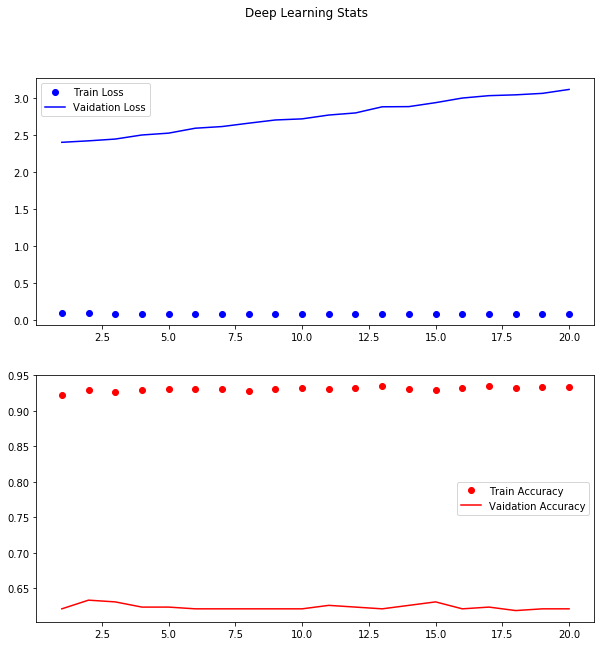

In [103]:
def plot_keras_history(model):
    history = model.history.history
    e = range(1, NB_START_EPOCHS + 1)
    
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Deep Learning Stats')
    ax1.plot(e, history['loss'], 'bo', label = 'Train Loss')
    ax1.plot(e, history['val_loss'], 'b', label = 'Vaidation Loss')
    ax2.plot(e, history['accuracy'], 'ro', label = 'Train Accuracy')
    ax2.plot(e, history['val_accuracy'], 'r', label = 'Vaidation Accuracy')

    ax1.legend()
    ax2.legend()
    plt.show()
    
plot_keras_history(base_model_fit)

This is overfitting somewhat aggressively, I am going to add some dropouts.

In [98]:
dropout_model = models.Sequential()
dropout_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
dropout_model.add(layers.Dropout(0.5))
dropout_model.add(layers.Dense(64, activation='relu'))
dropout_model.add(layers.Dropout(0.5))
dropout_model.add(layers.Dense(3, activation='softmax'))
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


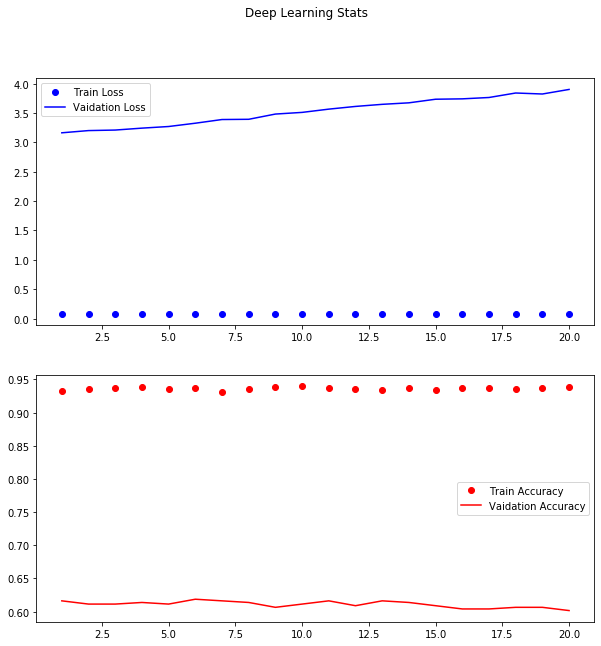

In [104]:
dropout_model_fit = compile_fit_model(base_model)
plot_keras_history(dropout_model_fit)

In [105]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,), kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                640064    
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


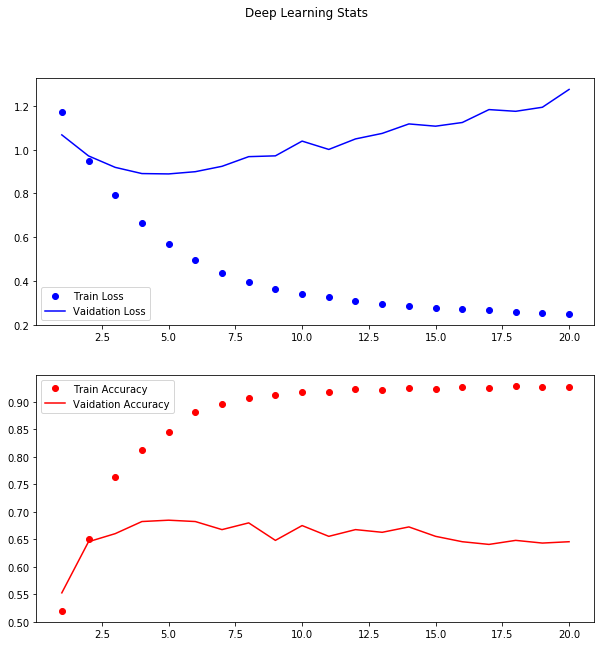

In [107]:
reg_model_fit = compile_fit_model(reg_model)
plot_keras_history(reg_model_fit)